In [99]:
import sys
sys.executable

'/anaconda3/envs/BI/bin/python'

In [100]:
import pandas as pd
import numpy as np
import pandas_profiling

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Read Data

In [101]:
ls data/

Cartelera2016.xlsx            solicitudes_enero_2018.xlsx
Casos_cambio_enero_2018.xlsx  subirsalones_2018-1.xls


In [151]:
df_cartelera_2016 = pd.read_excel('./data/Cartelera2016.xlsx')

In [152]:
df_cartelera_2016.head()

,N,Periodo,CRN,MATERIA,SECC,CRED,NOMBRE_CURSO,CUPO,INSC,DISP,...,M .2,I .2,J .2,V .2,S .2,PROFESOR1,PROFESOR2,PROFESOR3,Unnamed: 43,Unnamed: 44
0,1,2016-10,10126,ADMI-1101,1,3.0,FUNDAM.ADMON Y GERENCIA (ADMI),100,98,2,...,NaN,NaN,NaN,NaN,NaN,DIAZ MATAJIRA LUIS,OROZCO SILVA LUIS,,NaN,NaN
1,2,2016-10,11411,ADMI-1102,4,3.0,FUNDAM.ADMON Y GERENCIA,120,95,25,...,NaN,NaN,NaN,NaN,NaN,SCHNARCH GONZALEZ DAVID,DAVILA LADRON DE GUE CARLOS,PERALTA GUSTAVO,NaN,NaN
2,3,2016-10,12116,ADMI-1102,5,3.0,FUNDAM.ADMON Y GERENCIA,120,63,57,...,NaN,NaN,NaN,NaN,NaN,SCHNARCH GONZALEZ DAVID,DAVILA LADRON DE GUE CARLOS,RUIZ GUTIERREZ JAIME,NaN,NaN
3,4,2016-10,21175,ADMI-1102,6,3.0,FUNDAM.ADMON Y GEREN. (INGLES),40,14,26,...,NaN,NaN,NaN,NaN,NaN,FERRO CALVO MAURICIO,,,NaN,NaN
4,5,2016-10,20624,ADMI-1102C,1,0.0,FUNDAM.ADMON Y GERENCIA COMPL,40,31,9,...,NaN,NaN,NaN,NaN,NaN,PERALTA GUSTAVO,,,NaN,NaN


In [104]:
df_descripcion_salones = pd.read_excel('./data/subirsalones_2018-1.xls')

In [105]:
df_descripcion_salones.head()

,#,BLOQUE,SEÑALIZACIÓN,TIPO MOBILIARIO,FIJO/MOVIL,CAPACIDAD,ÁREA ÚTIL,EXT,MÓVIL XPRESS,DENSIDAD
0,1,Au,Au_101,Mesa trapezoidal con silla móviles,Movil,26,62.6,5601.0,Si,0.775837
1,2,Au,Au_102,Mesa trapezoidal con silla móviles,Movil,48,62.6,5602.0,Si,0.571001
2,3,Au,Au_103,Mesa trapezoidal con silla móviles,Movil,26,62.6,5603.0,Si,0.775837
3,4,Au,Au_104,Mesa trapezoidal con silla móviles,Movil,48,62.6,5604.0,Si,0.571001
4,5,Au,Au_107,"Silla móvil, mesa móvil",Movil,36,46.3,5605.0,Si,0.567034


# Preprocesamiento
### Descripción Salones

Se cambia la columna FIJO/MOVIL por la columna MOVIL, donde tomará el valor de 1 si las mesas del salón son móviles y 0 en caso contrario

In [110]:
df_descripcion_salones['FIJO/MOVIL'].value_counts()


Movil    102
Fijo      96
Name: FIJO/MOVIL, dtype: int64

In [111]:
salones = []

for i in range(len(df_descripcion_salones['FIJO/MOVIL'])):
    if df_descripcion_salones['FIJO/MOVIL'][i] == 'Movil':
        salones.append(1)
    elif df_descripcion_salones['FIJO/MOVIL'][i] == 'Fijo':
        salones.append(0)
        
df_descripcion_salones['FIJO/MOVIL'] = salones



In [112]:
df_descripcion_salones['FIJO/MOVIL'].value_counts()


1    102
0     96
Name: FIJO/MOVIL, dtype: int64

In [113]:
df_descripcion_salones.rename(columns={'FIJO/MOVIL': "MOVIL"}, inplace=True)

Se cambian los valores de la columna MÓVIL XPRESS por 1 en caso de que si llegue y 0 en caso contrario

In [114]:
df_descripcion_salones['MÓVIL XPRESS'].value_counts()

No                                  75
Si                                  75
SI                                  29
si                                  17
No (es salas de computo también)     2
Name: MÓVIL XPRESS, dtype: int64

In [115]:
col_movil_xpress = df_descripcion_salones.columns.get_loc('MÓVIL XPRESS')

indices_si = np.concatenate( (np.where(df_descripcion_salones['MÓVIL XPRESS'] == 'Si')[0], 
                              np.where(df_descripcion_salones['MÓVIL XPRESS'] == 'SI')[0],
                              np.where(df_descripcion_salones['MÓVIL XPRESS'] == 'si')[0])
                           )
for imam in indices_si:
    df_descripcion_salones.iloc[imam, col_movil_xpress] = 1
    
    
indices_no = np.concatenate( (np.where(df_descripcion_salones['MÓVIL XPRESS'] == 'No')[0], 
                              np.where(df_descripcion_salones['MÓVIL XPRESS'] == 'No (es salas de computo también)')[0])
                           )
for imam in indices_no:
    df_descripcion_salones.iloc[imam, col_movil_xpress] = 0

In [116]:
df_descripcion_salones['MÓVIL XPRESS'].value_counts()

1    121
0     77
Name: MÓVIL XPRESS, dtype: int64

Elimino columnas innecesarias. # Y EXT son identificadores únicos. ÁREA ÚTIL por su parte lo usé para calcular la densidad poblacional del salón de clases normalizada. 

In [117]:
del df_descripcion_salones['#']
del df_descripcion_salones['EXT']
del df_descripcion_salones['ÁREA ÚTIL']

Se generaliza(?) la columna TIPO MOBILIARIO. Se elimina la columna antes mencionada y se agregan PUPITRE, MESA ABATIBLE, MESA TRAPEZOIDAL. Para hacerlo tengo en cuenta estas consideraciones:
- Si la mesa es móvil entonces la silla también lo es
- Las únicas sillas fijas son las que vienen con la mesa abatible, que también es fija
- Pueden haber sillas móviles con mesas fijas. Sin embargo, que el valor de la columna MOVIL sea 1 solo depende de las   mesas, no de las sillas 

In [118]:
df_descripcion_salones['TIPO MOBILIARIO'].value_counts()

Silla móvil y mesa fija               87
Silla móvil, mesa móvil               56
Pupitre universitario                 38
Silla y superficie abatible fijas      9
Mesa trapezoidal con silla móviles     8
Name: TIPO MOBILIARIO, dtype: int64

In [119]:
pupitre = []
mesa_abatible = []
mesa_trapezoidal = []
for i in range(len(df_descripcion_salones['TIPO MOBILIARIO'])):
    if df_descripcion_salones['TIPO MOBILIARIO'][i] == 'Pupitre universitario':
        pupitre.append(1)
        mesa_abatible.append(0)
        mesa_trapezoidal.append(0)
    elif df_descripcion_salones['TIPO MOBILIARIO'][i] == 'Silla y superficie abatible fijas':
        pupitre.append(0)
        mesa_abatible.append(1)
        mesa_trapezoidal.append(0)
    elif df_descripcion_salones['TIPO MOBILIARIO'][i] == 'Mesa trapezoidal con silla móviles':
        pupitre.append(0)
        mesa_abatible.append(0)
        mesa_trapezoidal.append(1)
    else: 
        pupitre.append(0)
        mesa_abatible.append(0)
        mesa_trapezoidal.append(0)
        
df_descripcion_salones['PUPITRE'] = pupitre
df_descripcion_salones['MESA ABATIBLE'] = mesa_abatible
df_descripcion_salones['MESA TRAPEZOIDAL'] = mesa_trapezoidal


In [120]:
del df_descripcion_salones['TIPO MOBILIARIO']

In [121]:
df_descripcion_salones['MESA TRAPEZOIDAL'].value_counts()

0    190
1      8
Name: MESA TRAPEZOIDAL, dtype: int64

In [122]:
df_descripcion_salones['MESA ABATIBLE'].value_counts()

0    189
1      9
Name: MESA ABATIBLE, dtype: int64

In [123]:
df_descripcion_salones['PUPITRE'].value_counts()

0    160
1     38
Name: PUPITRE, dtype: int64

Se categoriza la columna CAPACIDAD. 

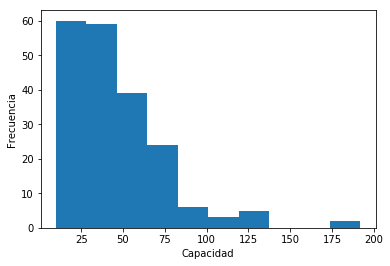

In [125]:
x = df_descripcion_salones['CAPACIDAD ']
plt.hist(x)
plt.ylabel('Frecuencia');
plt.xlabel('Capacidad');

In [126]:
def categoria_capacidad_salones(capacidad):
    categoria = 'muy pequeño'
    if capacidad >= 100:
            categoria = 'extra grande'
    elif capacidad >= 75:
            categoria = 'grande'
    elif capacidad >= 50:
            categoria = 'mediano'        
    elif capacidad >= 25:
            categoria = 'pequeño'
    
    return categoria

In [127]:
capacidades = df_descripcion_salones['CAPACIDAD ']
categorias_capacidades = []

for i in range(len(capacidades)):
    categorias_capacidades.append(categoria_capacidad_salones(capacidades[i]))

df_descripcion_salones['CAPACIDAD '] = categorias_capacidades

In [128]:
df_descripcion_salones['CAPACIDAD '].value_counts()

pequeño         90
mediano         42
muy pequeño     36
grande          19
extra grande    11
Name: CAPACIDAD , dtype: int64

Se categoriza la columna DENSIDAD

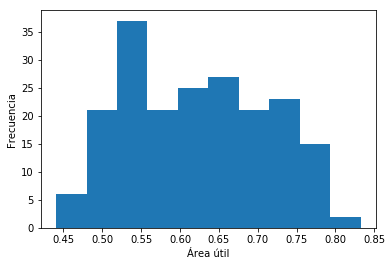

In [129]:
x = df_descripcion_salones['DENSIDAD']
plt.hist(x)
plt.ylabel('Frecuencia');
plt.xlabel('Área útil');

Entre más cercano sea el valor a 1, con más espacio se cuenta en el salón

In [142]:
def categoria_densidad(densidad):
    categoria = 'muy poblado'
    if densidad >= 0.75:
        categoria = 'muy amplio'
    elif densidad >= 0.65:
        categoria = 'amplio'
    elif densidad >= 0.50:
        categoria = 'poblado'            
    return categoria

In [143]:
densidades = df_descripcion_salones['DENSIDAD']
categorias_densidades = []

for i in range(len(densidades)):
    categorias_densidades.append(categoria_densidad(densidades[i]))

df_descripcion_salones['DENSIDAD'] = categorias_densidades

In [144]:
df_descripcion_salones.head()

,BLOQUE,SEÑALIZACIÓN,MOVIL,CAPACIDAD,MÓVIL XPRESS,DENSIDAD,PUPITRE,MESA ABATIBLE,MESA TRAPEZOIDAL
0,Au,Au_101,1,pequeño,1,muy amplio,0,0,1
1,Au,Au_102,1,pequeño,1,poblado,0,0,1
2,Au,Au_103,1,pequeño,1,muy amplio,0,0,1
3,Au,Au_104,1,pequeño,1,poblado,0,0,1
4,Au,Au_107,1,pequeño,1,poblado,0,0,0


### Cartelera 2016
La materia es un identificador único, pero uso el id como PK porque hay clases que no se dan siempre en el mismo salón (muy pocas), así que si materia se repite es porque corresponde a la misma clase, pero un diferente salón. En este caso solo se señalan los días de la semana en los que hay clase en el salón que aparece en la fila

In [147]:
df_cartelera_2016.columns

Index(['N', 'Periodo', 'CRN  ', ' MATERIA    ', 'SECC', 'CRED      ',
       'NOMBRE_CURSO        ', 'CUPO ', 'INSC', 'DISP ', 'HINI ', 'HFIN ',
       'SALON  ', 'CAP_S', 'L ', 'M ', 'I ', 'J ', 'V ', 'S ', 'HINI2',
       'HFIN2', 'SALON2 ', 'CAP_S.1', 'L .1', 'M .1', 'I .1', 'J .1', 'V .1',
       'S .1', 'HINI3', 'HFIN3', 'SALON3 ', 'CAP_S.2', 'L .2', 'M .2', 'I .2',
       'J .2', 'V .2', 'S .2', 'PROFESOR1                     ',
       'PROFESOR2                     ', 'PROFESOR3                     ',
       'Unnamed: 43', 'Unnamed: 44'],
      dtype='object')

In [153]:
del df_cartelera_2016['N']
del df_cartelera_2016['Periodo']
del df_cartelera_2016['CRN  ']
del df_cartelera_2016['SECC']
del df_cartelera_2016['CRED      ']
del df_cartelera_2016['NOMBRE_CURSO        ']
del df_cartelera_2016['DISP ']
del df_cartelera_2016['PROFESOR1                     ']
del df_cartelera_2016['PROFESOR2                     ']
del df_cartelera_2016['PROFESOR3                     ']

#Los siguientes valores los borro porque ya estan en la tabla de los salones
del df_cartelera_2016['CAP_S']
del df_cartelera_2016['CAP_S.1']
del df_cartelera_2016['CAP_S.2']

In [175]:
df_cartelera_2016.columns


Index([' MATERIA    ', 'CUPO ', 'INSC', 'HINI ', 'HFIN ', 'SALON  ', 'L ',
       'M ', 'I ', 'J ', 'V ', 'S ', 'HINI2', 'HFIN2', 'SALON2 ', 'L .1',
       'M .1', 'I .1', 'J .1', 'V .1', 'S .1', 'HINI3', 'HFIN3', 'SALON3 ',
       'L .2', 'M .2', 'I .2', 'J .2', 'V .2', 'S .2', 'Unnamed: 43',
       'Unnamed: 44'],
      dtype='object')

In [174]:
salones_2 = df_cartelera_2016['SALON2 ']

for i in range(len(salones_2)):
    if str(salones_2[i]) != 'nan' and str(salones_2[i]) != '----':
        df_cartelera_2016 = df_cartelera_2016.append([{' MATERIA    ':df_cartelera_2016[' MATERIA    '
                                                                                       
                                                                                       ]}], ignore_index=True)
        print(salones_2[i])


LL_303 
ML_511 
W_506  
SD_704 
SD_704 
SD_704 
AU_202 
AU_104 
ML_514 
LL_304 
LL_303 
ML_508 
O_304  
O_301  
ML_509 
O_203  
O_305  
SD_805 
SD_805 
AU_203 
AU_104 
ML_509 
B_201  
ML_511 
ML_511 
ML_509 
AU_204 
Y_101  
SD_801 
O_102  
ML_514 
T_206  
Z_228  
Z_227  
T_103  
Z_227  
Z_227  
T_206  
T_206  
T_103  
T_103  
Z_227  
Z_228  
T_104  
ML_111 
SD_803 
T_103  
ML_116 
T_206  
S1_301 
S1_301 
TX_503 
TX_503 
TX_504 
R_112  
TX_503 
ML_513 
ML_513 
ML_513 
ML_513 
ML_513 
ML_513 
AU_403 
ML_615 
ML_607 
Q_405  
O_103  
AU_205 
ML_617 
M_100  
SD_703 
SD_703 
LL_301 
AU_103 
AU_103 
O_102  
ML_608 
Q_405  
ML_617 
O_104  
O_205  
O_101  
ML_607 
SD_715 
Z_203  
NOREQ  
NOREQ  
ML_512 
W_403  
W_403  
ML_513 
ML_513 
LL_001 
LL_002 
LL_002 
S1_202 
B_402  
LL_304 
R_209  
AU_104 
W_503  
O_304  
O_301  
RGC_218
RGC_218
AU_206 
AU_401 
W_505  
LL_101 
O_201  
O_405  
Q_307  
O_201  
Z_203  
W_201  
Z_212  
RGC_218
ML_614 
AU_312 
AU_307 
W_203  
AU_206 
Z_213  
LL_206 
S1_003 


# Dimensión: Salón
### id (PK) | señalización | bloque | movil | capacidad | área útil | móvil xpress | pupitre | mesa abatible | mesa trapezoidal

# Dimensión: Clase
### id (PK) | materia | cupo | inscritos   

# Dimensión: Fecha
### id (PK) |  L | M | I | J | V | S | hora  inicio | hora fin

# Fact Table: Uso Salones
### id (PK) | id_salon (FK) | id_clase (FK) | id_fecha (FK)  | duracion(min)